In [103]:
import tweepy
import json
from bs4 import BeautifulSoup
import requests
from retry import retry
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import scipy.stats as stats
import statistics
%matplotlib inline 

In [6]:
#Insert real values here
consumer_key = "not-the-real-consumer-key"
consumer_secret = "not-the-real-consumer-secret"
access_token = "not-the-real-access-token"
access_token_secret = "not-the-real-access-token-secret"
bearer_token = "not-the-real-bearer-token"

In [89]:
#Tweet Categories
long_text_photo = 'long_text_photo' 
short_text_photo = 'short_text_photo'
link_text = 'link_text' 
long_text = 'long_text' 
short_text = 'short_text' 
video = 'video'

In [23]:
accounts=["who", "CDCgov", "US_FDA", "MoHFW_INDIA", "DHSCgovuk", "HHSGov", "DOHgovph", "ECDC_EU", "American_Heart", "IDSAInfo", "POTUS", "mygovindia", "AAPDelhi", "GoI_MeitY", "PMOIndia", "UKParliament", "GOVUK", "HouseofCommons", "EU_Commission", "NATO", "UNGeneva", "french_gov", "CanadianPM", "GovtofPakistan", "scotgov", "scotgovhealth", "metpoliceuk", "DelhiPolice", "MumbaiPolice", "BlrCityPolice", "FBI", "CIA"]

In [24]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)
client = tweepy.Client(bearer_token=bearer_token)

In [25]:
def extract_entity_from_tweet(tweet_json):
    if 'extended_entities' in tweet_json:
        return tweet_json['extended_entities']['media'][0]['type']
    elif 'entities' in tweet_json:
        if 'urls' in tweet_json['entities']:
            if any("youtu.be" in item['expanded_url'] for item in tweet_json['entities']['urls']):
                return 'video'

@retry(Exception, delay=16*60, tries=-1)
def fetch_tweet_info_with_client(tweet_json):
    return client.get_tweet(tweet_json['id'], \
      tweet_fields=["public_metrics"])

def tweet_to_metrics_and_type(tweet):
    tweet_json = tweet._json
    client_result = fetch_tweet_info_with_client(tweet_json)
    tweet = client_result.data
    tweet_metrics = tweet.public_metrics
    tweet_metrics['id'] = tweet_json['id']
    tweet_metrics['full_text'] = tweet_json['full_text']
    tweet_type = extract_entity_from_tweet(tweet_json)
    tweet_metrics['type'] = "text" if not tweet_type else tweet_type
    return tweet_metrics

In [26]:
tweets = {}
for account in accounts:
    tweet_jsons = api.user_timeline(screen_name=account, 
                           count=1000,
                           include_rts = False,
                           tweet_mode = 'extended'
                           )
    account_followers = tweet_jsons[0]._json['user']['followers_count']
    account_tweets = list(map(tweet_to_metrics_and_type, tweet_jsons))
    tweets[account] = {"account_followers": account_followers, "account_tweets": account_tweets}

In [35]:
with open('tweets_with_text.json', 'w') as fp:
    json.dump(tweets, fp)

# with open('tweets_with_text.json') as json_file:
#     tweets = json.load(json_file)

In [90]:
long_text_photos = 0
short_text_photos = 0
link_texts = 0
long_texts = 0
short_texts = 0
videos = 0
for key in tweets.keys():
    for tweet in tweets[key]['account_tweets']:
        if tweet['type'] == 'photo':
            if len(tweet['full_text']) >= 150:
                tweet['parsed_type'] = long_text_photo
                long_text_photos = long_text_photos + 1
            else:
                tweet['parsed_type'] = short_text_photo
                short_text_photos = short_text_photos + 1
        elif tweet['type'] == 'text':
            if "https://" in tweet['full_text'] or "http://" in tweet['full_text']:
                tweet['parsed_type'] = link_text
                link_texts = link_texts + 1
            elif len(tweet['full_text']) >= 150:
                tweet['parsed_type'] = long_text
                long_texts = long_texts + 1
            else:
                tweet['parsed_type'] = short_text
                short_texts = short_texts + 1
        else:
            tweet['parsed_type'] = video
            videos = videos + 1

In [74]:
print(long_text_photos, short_text_photos, link_texts, long_texts, short_texts, videos)

1515 228 830 829 643 508


In [92]:
video_tweets_combined = []
long_text_photo_tweets_combined = []
short_text_photo_tweets_combined = []
link_text_tweets_combined = []
long_text_tweets_combined = []
short_text_tweets_combined = []
for key in tweets.keys():
    account_followers = tweets[key]['account_followers']
    for tweet in tweets[key]['account_tweets']:
        tweet_without_id = dict((k, tweet[k]) for k in ['retweet_count', 'reply_count', 'like_count'])
        normalised_tweet = {k:v/account_followers for k,v in tweet_without_id.items()}
        if tweet['parsed_type'] == long_text_photo:
            long_text_photo_tweets_combined.append(normalised_tweet)
        elif tweet['parsed_type'] == short_text_photo:
            short_text_photo_tweets_combined.append(normalised_tweet)
        elif tweet['parsed_type'] == link_text:
            link_text_tweets_combined.append(normalised_tweet)
        elif tweet['parsed_type'] == long_text:
            long_text_tweets_combined.append(normalised_tweet)
        elif tweet['parsed_type'] == short_text:
            short_text_tweets_combined.append(normalised_tweet)    
        else:
            video_tweets_combined.append(normalised_tweet)

In [93]:
print(len(long_text_photo_tweets_combined), len(short_text_photo_tweets_combined),
      len(link_text_tweets_combined), len(long_text_tweets_combined),
      len(short_text_tweets_combined), len(video_tweets_combined))

1515 228 830 829 643 508


In [122]:
def extract_component(long_text_photo_tweets_combined, short_text_photo_tweets_combined, link_text_tweets_combined, long_text_tweets_combined, short_text_tweets_combined, video_tweets_combined, extraction_function):
    long_text_photo_tweets_component = list(map(extraction_function, long_text_photo_tweets_combined))
    short_text_photo_tweets_component = list(map(extraction_function, short_text_photo_tweets_combined))
    link_text_tweets_component = list(map(extraction_function, link_text_tweets_combined))
    long_text_tweets_component = list(map(extraction_function, long_text_tweets_combined))
    short_text_tweets_component = list(map(extraction_function, short_text_tweets_combined))
    video_component = list(map(retweet, video_tweets_combined))
    return long_text_photo_tweets_component, short_text_photo_tweets_component, link_text_tweets_component, long_text_tweets_component, short_text_tweets_component, video_component

In [133]:
def retweet(tweet):
    return tweet['retweet_count']
long_text_photo_tweets_retweets, short_text_photo_tweets_retweets, link_text_tweets_retweets, long_text_tweets_retweets, short_text_tweets_retweets, video_retweets = extract_component(long_text_photo_tweets_combined, short_text_photo_tweets_combined, link_text_tweets_combined, long_text_tweets_combined, short_text_tweets_combined, video_tweets_combined, retweet)
long_text_photo_tweets_retweets = [x for x in long_text_photo_tweets_retweets if x <= 0.002]
short_text_photo_tweets_retweets = [x for x in short_text_photo_tweets_retweets if x <= 0.002]
link_text_tweets_retweets = [x for x in link_text_tweets_retweets if x <= 0.002]
long_text_tweets_retweets = [x for x in long_text_tweets_retweets if x <= 0.002]
short_text_tweets_retweets = [x for x in short_text_tweets_retweets if x <= 0.002]
video_retweets = [x for x in video_retweets if x <= 0.003]

In [134]:
print(len(long_text_photo_tweets_retweets), len(short_text_photo_tweets_retweets), len(link_text_tweets_retweets), len(long_text_tweets_retweets), len(short_text_tweets_retweets), len(video_retweets))

1513 228 829 828 643 508


In [135]:
df_retweet = pd.DataFrame(list(itertools.zip_longest(long_text_photo_tweets_retweets, short_text_photo_tweets_retweets, link_text_tweets_retweets, long_text_tweets_retweets, short_text_tweets_retweets, video_retweets)),columns =['long_text_photo', 'short_text_photo', 'link_text', 'long_text', 'short_text', 'video'])
df_retweet['index'] = df_retweet.index
df_retweet_melt = pd.melt(df_retweet.reset_index(), id_vars=['index'], value_vars=['long_text_photo', 'short_text_photo', 'link_text', 'long_text', 'short_text', 'video'])
df_retweet_melt.dropna(subset = ["value"], inplace=True)
df_retweet_melt.reset_index(inplace=True)
df_retweet_melt['index'] = df_retweet_melt.index
df_retweet_melt.drop('level_0', axis=1, inplace=True)
df_retweet_melt.columns = ['index', 'tweet type', 'normalised retweet value']
df_retweet_melt

,index,tweet type,normalised retweet value
0,0,long_text_photo,0.000002
1,1,long_text_photo,0.000002
2,2,long_text_photo,0.000002
3,3,long_text_photo,0.000006
4,4,long_text_photo,0.000028
...,...,...,...
4544,4544,video,0.000039
4545,4545,video,0.000012
4546,4546,video,0.000025
4547,4547,video,0.000086


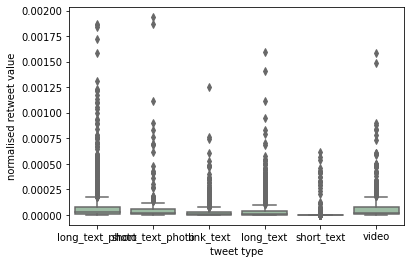

In [136]:
ax = sns.boxplot(x='tweet type', y='normalised retweet value', data=df_retweet_melt, color='#99c2a2')
plt.show()

In [131]:
stats.kruskal(long_text_photo_tweets_retweets, short_text_photo_tweets_retweets, link_text_tweets_retweets, long_text_tweets_retweets, short_text_tweets_retweets, video_retweets)

KruskalResult(statistic=1187.170370349343, pvalue=1.765691904469306e-254)

In [132]:
print(statistics.mean(long_text_photo_tweets_retweets), statistics.mean(short_text_photo_tweets_retweets), statistics.mean(link_text_tweets_retweets), statistics.mean(long_text_tweets_retweets), statistics.mean(short_text_tweets_retweets), statistics.mean(video_retweets))

9.789183495505093e-05 8.721061318443697e-05 3.7771726945693584e-05 5.876636519193101e-05 1.5077125581311232e-05 8.322756946022994e-05


In [137]:
def like(tweet):
    return tweet['like_count']
long_text_photo_tweets_likes, short_text_photo_tweets_likes, link_text_tweets_likes, long_text_tweets_likes, short_text_tweets_likes, video_likes = extract_component(long_text_photo_tweets_combined, short_text_photo_tweets_combined, link_text_tweets_combined, long_text_tweets_combined, short_text_tweets_combined, video_tweets_combined, like)
long_text_photo_tweets_likes = [x for x in long_text_photo_tweets_likes if x <= 0.002]
short_text_photo_tweets_likes = [x for x in short_text_photo_tweets_likes if x <= 0.002]
link_text_tweets_likes = [x for x in link_text_tweets_likes if x <= 0.002]
long_text_tweets_likes = [x for x in long_text_tweets_likes if x <= 0.002]
short_text_tweets_likes = [x for x in short_text_tweets_likes if x <= 0.002]
video_likes = [x for x in video_likes if x <= 0.002]

In [138]:
df_likes = pd.DataFrame(list(itertools.zip_longest(long_text_photo_tweets_likes, short_text_photo_tweets_likes, link_text_tweets_likes, long_text_tweets_likes, short_text_tweets_likes, video_likes)),columns =['long_text_photo', 'short_text_photo', 'link_text', 'long_text', 'short_text', 'video'])
df_likes['index'] = df_likes.index
df_likes_melt = pd.melt(df_likes.reset_index(), id_vars=['index'], value_vars=['long_text_photo', 'short_text_photo', 'link_text', 'long_text', 'short_text', 'video'])
df_likes_melt.dropna(subset = ["value"], inplace=True)
df_likes_melt.reset_index(inplace=True)
df_likes_melt['index'] = df_likes_melt.index
df_likes_melt.drop('level_0', axis=1, inplace=True)
df_likes_melt.columns = ['index', 'tweet type', 'normalised likes value']
df_likes_melt

,index,tweet type,normalised likes value
0,0,long_text_photo,0.000005
1,1,long_text_photo,0.000007
2,2,long_text_photo,0.000007
3,3,long_text_photo,0.000022
4,4,long_text_photo,0.000050
...,...,...,...
4476,4476,video,0.000039
4477,4477,video,0.000012
4478,4478,video,0.000025
4479,4479,video,0.000086


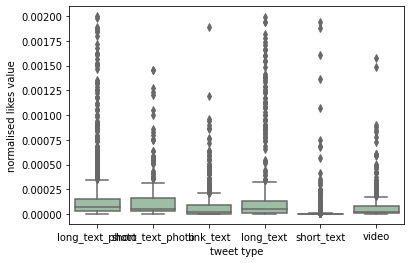

In [139]:
ax = sns.boxplot(x='tweet type', y='normalised likes value', data=df_likes_melt, color='#99c2a2')
plt.show()

In [141]:
stats.kruskal(long_text_photo_tweets_likes, short_text_photo_tweets_likes, link_text_tweets_likes, long_text_tweets_likes, short_text_tweets_likes, video_likes)

KruskalResult(statistic=1094.6053594638252, pvalue=1.9695234490228915e-234)

In [142]:
print(statistics.mean(long_text_photo_tweets_likes), statistics.mean(short_text_photo_tweets_likes), statistics.mean(link_text_tweets_likes), statistics.mean(long_text_tweets_likes), statistics.mean(short_text_tweets_likes), statistics.mean(video_likes))

0.00016432818756846902 0.00016309804535125775 8.18252573047842e-05 0.00015931596243688013 2.971040446783683e-05 8.322756946022994e-05


In [146]:
def reply(tweet):
    return tweet['reply_count']
long_text_photo_tweets_replies, short_text_photo_tweets_replies, link_text_tweets_replies, long_text_tweets_replies, short_text_tweets_replies, video_replies = extract_component(long_text_photo_tweets_combined, short_text_photo_tweets_combined, link_text_tweets_combined, long_text_tweets_combined, short_text_tweets_combined, video_tweets_combined, reply)
long_text_photo_tweets_replies = [x for x in long_text_photo_tweets_replies if x <= 0.002]
short_text_photo_tweets_replies = [x for x in short_text_photo_tweets_replies if x <= 0.002]
link_text_tweets_replies = [x for x in link_text_tweets_replies if x <= 0.002]
long_text_tweets_replies = [x for x in long_text_tweets_replies if x <= 0.002]
short_text_tweets_replies = [x for x in short_text_tweets_replies if x <= 0.002]
video_replies = [x for x in video_replies if x <= 0.002]

In [147]:
df_replies = pd.DataFrame(list(itertools.zip_longest(long_text_photo_tweets_replies, short_text_photo_tweets_replies, link_text_tweets_replies, long_text_tweets_replies, short_text_tweets_replies, video_replies)),columns =['long_text_photo', 'short_text_photo', 'link_text', 'long_text', 'short_text', 'video'])
df_replies['index'] = df_replies.index
df_replies_melt = pd.melt(df_replies.reset_index(), id_vars=['index'], value_vars=['long_text_photo', 'short_text_photo', 'link_text', 'long_text', 'short_text', 'video'])
df_replies_melt.dropna(subset = ["value"], inplace=True)
df_replies_melt.reset_index(inplace=True)
df_replies_melt['index'] = df_replies_melt.index
df_replies_melt.drop('level_0', axis=1, inplace=True)
df_replies_melt.columns = ['index', 'tweet type', 'normalised reply value']
df_replies_melt

,index,tweet type,normalised reply value
0,0,long_text_photo,9.389849e-08
1,1,long_text_photo,8.450864e-07
2,2,long_text_photo,1.877970e-07
3,3,long_text_photo,1.971868e-06
4,4,long_text_photo,6.103402e-06
...,...,...,...
4547,4547,video,3.888602e-05
4548,4548,video,1.198742e-05
4549,4549,video,2.455959e-05
4550,4550,video,8.573264e-05


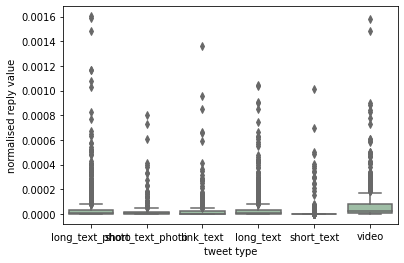

In [148]:
az = sns.boxplot(x='tweet type', y='normalised reply value', data=df_replies_melt, color='#99c2a2')
plt.show()

In [149]:
stats.kruskal(long_text_photo_tweets_replies, short_text_photo_tweets_replies, link_text_tweets_replies, long_text_tweets_replies, short_text_tweets_replies, video_replies)

KruskalResult(statistic=966.9020870354694, pvalue=8.792631397964216e-207)

In [150]:
print(statistics.mean(long_text_photo_tweets_replies), statistics.mean(short_text_photo_tweets_replies), statistics.mean(link_text_tweets_replies), statistics.mean(long_text_tweets_replies), statistics.mean(short_text_tweets_replies), statistics.mean(video_replies))

4.318017709161239e-05 3.829362582224144e-05 2.6718203318352755e-05 4.8026460017266505e-05 1.258951781228251e-05 8.322756946022994e-05
